# Alzheimer stage classification

## Install requirements

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Dataset Extraction

At this stage, we extract the dataframes from the .csv files. The goal is to obtain the starting point for further processing of the dataset.

The dataset contains information for 1256 patients. In particular, we will extract information from the following files:

* df_concat_final.csv: contains miRNA values collected for each patient, with some additional personal data
* subj_embeddings_train.csv: contains miRNA feature embeddings (128 features per patient)

The final result is a dataframe whose dimension are (1256 x 134), where the rows represent the patients while the columns represent both the miRNA embeddings and some personal info (country, age, sex, APOE4, disease).

In [2]:
import pandas as pd

# extract the corresponding dataframe from CSV files
df_patient_data = pd.read_csv('data/raw/df_concat_final.csv')
df_patient_mirna_embeddings = pd.read_csv('data/raw/subj_embeddings_train.csv')

In [3]:
# obtain a new dataframe from df_patient_data, selecting only columns defined in relevant_info_list

relevant_info_list = ['Unnamed: 0', 'country', 'age', 'sex', 'apoe4', 'disease']

# check if all the columns in relevant_info_list are column names in df_patient_data
for col in relevant_info_list:
    if col not in df_patient_data.columns:
        print(f"Column '{col}' is not in the dataframe")

# remove columns not in relevant_info_list from df_patient_data
df_patient_data = df_patient_data[relevant_info_list]

In [4]:
# merge the two dataframes (df_patient_data, df_patient_mirna_embeddings) over 'Unnamed: 0' column
df_merged = pd.merge(df_patient_data, df_patient_mirna_embeddings, on='Unnamed: 0')

print(df_merged.head())
print(df_merged.shape)

  Unnamed: 0 country   age     sex  apoe4 disease         0         1  \
0    AD_0001   Japan  79.0  female    0.0      AD  0.066932 -0.091154   
1    AD_0002   Japan  77.0  female    1.0      AD  0.065803 -0.090826   
2    AD_0003   Japan  76.0  female    0.0      AD  0.065981 -0.090561   
3    AD_0005   Japan  74.0    male    0.0      AD  0.067919 -0.091466   
4    AD_0006   Japan  83.0  female    0.0      AD  0.069397 -0.091897   

          2         3  ...       118       119       120       121       122  \
0 -0.009125  0.097251  ... -0.234498  0.090326 -0.067787 -0.076903  0.099299   
1 -0.008517  0.097001  ... -0.233551  0.090227 -0.066737 -0.073755  0.096548   
2 -0.007946  0.097332  ... -0.233344  0.089428 -0.066942 -0.074739  0.097539   
3 -0.010179  0.097227  ... -0.235832  0.089802 -0.069728 -0.079434  0.102334   
4 -0.011155  0.097552  ... -0.237290  0.090446 -0.070879 -0.080586  0.103140   

        123       124       125       126       127  
0  0.066471 -0.099358  0.0

In [5]:
# save dataframe in a file
df_merged.to_csv('data/processed/dataset.csv', index=False)

## Data Cleaning

### Normalize miRNA embedding values

The 128 miRNA features may have different ranges and variances. Without normalization, features with larger numeric scales could dominate the learning process, regardless of their true predictive value.

We apply z-score normalization, to ensure that each feature has mean 0 and standard deviation 1.

It is also essential before PCA, which is variance-based and would otherwise be biased by feature scale.

In [6]:
# extract dataframe from csv
df_merged = pd.read_csv('data/processed/dataset.csv')

In [7]:
relevant_info_list = ['Unnamed: 0', 'country', 'age', 'sex', 'apoe4', 'disease']

# remove relevant_info_list columns from df_merged
df_miRNA_features = df_merged.drop(columns=relevant_info_list)

# check types in df_miRNA_features
print(df_miRNA_features.dtypes)

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
123    float64
124    float64
125    float64
126    float64
127    float64
Length: 128, dtype: object


In [8]:
print(df_miRNA_features.head().to_markdown())

|    |         0 |          1 |           2 |         3 |          4 |         5 |        6 |         7 |          8 |         9 |         10 |       11 |       12 |       13 |         14 |        15 |          16 |         17 |         18 |       19 |       20 |        21 |          22 |        23 |        24 |         25 |        26 |        27 |         28 |       29 |        30 |         31 |        32 |        33 |        34 |       35 |       36 |          37 |        38 |        39 |         40 |        41 |       42 |        43 |         44 |         45 |       46 |        47 |         48 |       49 |         50 |          51 |       52 |         53 |       54 |         55 |        56 |        57 |         58 |         59 |         60 |         61 |        62 |        63 |       64 |        65 |       66 |        67 |        68 |         69 |          70 |       71 |         72 |        73 |       74 |        75 |        76 |         77 |         78 |         79 |        80 |  

In [9]:
# normalize values of df_miRNA_features

df_miRNA_features = (df_miRNA_features - df_miRNA_features.mean()) / df_miRNA_features.std()

print(df_miRNA_features.head().to_markdown())

|    |         0 |          1 |          2 |         3 |         4 |           5 |         6 |          7 |          8 |          9 |         10 |        11 |        12 |          13 |         14 |         15 |         16 |         17 |          18 |         19 |         20 |         21 |         22 |         23 |         24 |         25 |         26 |         27 |           28 |        29 |        30 |         31 |         32 |         33 |         34 |          35 |        36 |         37 |          38 |        39 |          40 |        41 |        42 |        43 |         44 |         45 |        46 |         47 |          48 |        49 |          50 |         51 |         52 |         53 |         54 |          55 |          56 |         57 |         58 |         59 |         60 |         61 |         62 |         63 |        64 |         65 |        66 |         67 |          68 |           69 |         70 |        71 |         72 |         73 |         74 |         75 |         

### Non-related miRNA info analysis

Let's move on from analyzing biometric features to analyzing the remaining features. Specifically, we will analyze whether there are any values that fall outside the norm.

In [10]:
relevant_info_list = ['Unnamed: 0', 'country', 'age', 'sex', 'apoe4', 'disease']

# remove columns not in relevant_info_list from df_merged
df_info = df_merged[relevant_info_list]

# check types in df_info
print(df_info.dtypes)

Unnamed: 0     object
country        object
age           float64
sex            object
apoe4         float64
disease        object
dtype: object


In [11]:
# for each column, count the frequency of missing values
for col in df_info.columns:
    missing_count = df_info[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count} missing values")


age: 29 missing values
sex: 29 missing values
apoe4: 29 missing values


In [12]:
# memorize the ids corresponding to missing values
missing_ids = df_info[df_info.isnull().any(axis=1)].index.tolist()

print(missing_ids)

[1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255]


### Remove rows of patients having missing values

The analysis related to features not correlated with miRNA showed the existence of zero values for the features ‘age’, ‘sex’, and ‘apoe4’. Since the number of rows with this problem is small compared to the total, the simplest and most effective idea is to remove these rows. 

In [13]:
# remove rows of patients having missing values in both df_miRNA_features and df_merged
df_miRNA_features = df_miRNA_features.drop(index=missing_ids)
df_merged = df_merged.drop(index=missing_ids)

print(df_miRNA_features.shape)
print(df_merged.shape)

(1227, 128)
(1227, 134)


### Update the dataset dataframe to the normalized values

In [14]:
relevant_info_list = ['Unnamed: 0', 'country', 'age', 'sex', 'apoe4', 'disease']

# remove columns in relevant_info_list from df_merged
df_merged = df_merged[relevant_info_list]

# add columns from df_miRNA_features to df_merged
df_merged = pd.concat([df_merged, df_miRNA_features], axis=1)

print(df_merged.head().to_markdown())

|    | Unnamed: 0   | country   |   age | sex    |   apoe4 | disease   |         0 |          1 |          2 |         3 |         4 |           5 |         6 |          7 |          8 |          9 |         10 |        11 |        12 |          13 |         14 |         15 |         16 |         17 |          18 |         19 |         20 |         21 |         22 |         23 |         24 |         25 |         26 |         27 |           28 |        29 |        30 |         31 |         32 |         33 |         34 |          35 |        36 |         37 |          38 |        39 |          40 |        41 |        42 |        43 |         44 |         45 |        46 |         47 |          48 |        49 |          50 |         51 |         52 |         53 |         54 |          55 |          56 |         57 |         58 |         59 |         60 |         61 |         62 |         63 |        64 |         65 |        66 |         67 |          68 |           69 |         70 |       

### Change biomarkers' column names 

In [15]:
# modify every column name being a digit, adding 'miRNA_feature_' prefix
df_merged.columns = [f"miRNA_feature_{col}" if col.isdigit() else col for col in df_merged.columns]

print(df_merged.head().to_markdown())

|    | Unnamed: 0   | country   |   age | sex    |   apoe4 | disease   |   miRNA_feature_0 |   miRNA_feature_1 |   miRNA_feature_2 |   miRNA_feature_3 |   miRNA_feature_4 |   miRNA_feature_5 |   miRNA_feature_6 |   miRNA_feature_7 |   miRNA_feature_8 |   miRNA_feature_9 |   miRNA_feature_10 |   miRNA_feature_11 |   miRNA_feature_12 |   miRNA_feature_13 |   miRNA_feature_14 |   miRNA_feature_15 |   miRNA_feature_16 |   miRNA_feature_17 |   miRNA_feature_18 |   miRNA_feature_19 |   miRNA_feature_20 |   miRNA_feature_21 |   miRNA_feature_22 |   miRNA_feature_23 |   miRNA_feature_24 |   miRNA_feature_25 |   miRNA_feature_26 |   miRNA_feature_27 |   miRNA_feature_28 |   miRNA_feature_29 |   miRNA_feature_30 |   miRNA_feature_31 |   miRNA_feature_32 |   miRNA_feature_33 |   miRNA_feature_34 |   miRNA_feature_35 |   miRNA_feature_36 |   miRNA_feature_37 |   miRNA_feature_38 |   miRNA_feature_39 |   miRNA_feature_40 |   miRNA_feature_41 |   miRNA_feature_42 |   miRNA_feature_43 |   miRNA_featu

## Feature Reduction

There are numerous features, and considering the limited number of examples in the dataset, it may be appropriate to reduce them. We proceed as follows

First, we eliminate uninformative features, as well as patient identifiers that are superfluous and misleading in machine learning experiments.

Subsequently, since the biometric dataset contains 128 featues, we apply Principal Component Analysis to reduce dimensionality.

PCA transforms the original features into a smaller set of uncorrelated principal components, ordered by the variance they explain. In our case, we retained 20 components, which toghether account for about the 99% of the total variance.

In [16]:
# Remove "Unnamed: 0" column, representing the identificator
df_merged = df_merged.drop(columns=["Unnamed: 0"])

# Remove "country", since it is not very informative because of its distribution
df_merged = df_merged.drop(columns=["country"])

In [17]:
# Modify "sex" column to be binary

# print "sex" column type
print(df_merged["sex"].dtype)

# turn "sex" column type from object to category
df_merged["sex"] = df_merged["sex"].astype("category")

# turn categories in "sex" column to binary
df_merged["sex"] = df_merged["sex"].cat.codes   

object


In [18]:
# Modify "disease" column to be ternary

print(df_merged["disease"].dtype)

# turn "disease" column type from object to category
df_merged["disease"] = df_merged["disease"].astype("category")

# turn categories in "disease" column to ternary (AD = 0, MCI = 1, CN = 2)
df_merged["disease"] = df_merged["disease"].cat.codes

object


In [19]:
print(df_merged.head().to_markdown())

|    |   age |   sex |   apoe4 |   disease |   miRNA_feature_0 |   miRNA_feature_1 |   miRNA_feature_2 |   miRNA_feature_3 |   miRNA_feature_4 |   miRNA_feature_5 |   miRNA_feature_6 |   miRNA_feature_7 |   miRNA_feature_8 |   miRNA_feature_9 |   miRNA_feature_10 |   miRNA_feature_11 |   miRNA_feature_12 |   miRNA_feature_13 |   miRNA_feature_14 |   miRNA_feature_15 |   miRNA_feature_16 |   miRNA_feature_17 |   miRNA_feature_18 |   miRNA_feature_19 |   miRNA_feature_20 |   miRNA_feature_21 |   miRNA_feature_22 |   miRNA_feature_23 |   miRNA_feature_24 |   miRNA_feature_25 |   miRNA_feature_26 |   miRNA_feature_27 |   miRNA_feature_28 |   miRNA_feature_29 |   miRNA_feature_30 |   miRNA_feature_31 |   miRNA_feature_32 |   miRNA_feature_33 |   miRNA_feature_34 |   miRNA_feature_35 |   miRNA_feature_36 |   miRNA_feature_37 |   miRNA_feature_38 |   miRNA_feature_39 |   miRNA_feature_40 |   miRNA_feature_41 |   miRNA_feature_42 |   miRNA_feature_43 |   miRNA_feature_44 |   miRNA_feature_45 |

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# extract biometrical features
excluded_features = ["sex", "age", "apoe4", "disease"]
df_biometrical = df_merged.drop(columns=excluded_features)

# standardization
scaler = StandardScaler()
df_biometrical_scaled = scaler.fit_transform(df_biometrical)

# PCA transformation
pca = PCA(n_components=20)
df_biometrical_pca = pca.fit_transform(df_biometrical_scaled)

# Creating PCA dataframe
df_biometrical_pca = pd.DataFrame(
    df_biometrical_pca,
    columns=[f"PC{i+1}" for i in range(df_biometrical_pca.shape[1])]
)

print(df_biometrical_pca.shape)
print(df_biometrical_pca.head().to_markdown())


df_final = pd.concat(
    [df_merged[["age", "sex", "apoe4", "disease"]].reset_index(drop=True),
     df_biometrical_pca.reset_index(drop=True)],
    axis=1
)


(1227, 20)
|    |      PC1 |         PC2 |        PC3 |        PC4 |         PC5 |       PC6 |       PC7 |        PC8 |        PC9 |       PC10 |        PC11 |       PC12 |       PC13 |         PC14 |       PC15 |        PC16 |       PC17 |       PC18 |       PC19 |       PC20 |
|---:|---------:|------------:|-----------:|-----------:|------------:|----------:|----------:|-----------:|-----------:|-----------:|------------:|-----------:|-----------:|-------------:|-----------:|------------:|-----------:|-----------:|-----------:|-----------:|
|  0 | 0.603741 | -0.00495067 | -0.19775   | -0.311204  | -0.00621848 |  0.070266 | 0.168576  |  0.0218985 | -0.0479032 | -0.0025658 | -0.033393   | -0.106827  | -0.142248  |  0.000488479 | -0.0191877 | -0.00118097 |  0.0438957 | -0.148423  | -0.0683146 | -0.0124846 |
|  1 | 0.364554 |  0.608776   | -0.0784338 |  0.0410796 |  0.0643598  | -0.091476 | 0.11177   | -0.0249862 | -0.0019539 | -0.0414287 |  0.0182438  | -0.0598594 |  0.0178495 |  0.0551

Selection of the number of principal components: the first 20 principal components were selected, capable of explaining over 99% of the total variance. This ensures an excellent compromise between reducing the dimensionality of the model and preserving information.         

In [21]:
# compute the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# sum explained_variance values
total_explained_variance = explained_variance.sum()

print(explained_variance)
print(total_explained_variance)

[0.37726911 0.19832111 0.07931048 0.06935265 0.05523476 0.04722751
 0.04081841 0.03031943 0.02119722 0.01338584 0.01129597 0.01005197
 0.00747951 0.00636794 0.00535316 0.00465566 0.00405487 0.00327813
 0.00303115 0.00275436]
0.9907592439838507


In [22]:
# Obtain the final dataframe, composed by the removed columns and the new extracted PC
df_final = pd.concat([df_merged[excluded_features].reset_index(drop=True), df_biometrical_pca], axis=1)

print(df_final.shape)
print(df_final.head().to_markdown())

(1227, 24)
|    |   sex |   age |   apoe4 |   disease |      PC1 |         PC2 |        PC3 |        PC4 |         PC5 |       PC6 |       PC7 |        PC8 |        PC9 |       PC10 |        PC11 |       PC12 |       PC13 |         PC14 |       PC15 |        PC16 |       PC17 |       PC18 |       PC19 |       PC20 |
|---:|------:|------:|--------:|----------:|---------:|------------:|-----------:|-----------:|------------:|----------:|----------:|-----------:|-----------:|-----------:|------------:|-----------:|-----------:|-------------:|-----------:|------------:|-----------:|-----------:|-----------:|-----------:|
|  0 |     0 |    79 |       0 |         0 | 0.603741 | -0.00495067 | -0.19775   | -0.311204  | -0.00621848 |  0.070266 | 0.168576  |  0.0218985 | -0.0479032 | -0.0025658 | -0.033393   | -0.106827  | -0.142248  |  0.000488479 | -0.0191877 | -0.00118097 |  0.0438957 | -0.148423  | -0.0683146 | -0.0124846 |
|  1 |     0 |    77 |       1 |         0 | 0.364554 |  0.608776   

## Defining models to compare

The modeling phase has a twofold objective:

1. Evaluate the effect of feature reduction - we first compare model performance with and without PCA to verify whether dimensionality reduction improves classification results.

2. Test more advanced classifiers - beyond the Baseline Random Forest, we assess more complex models to investigate whether alternative approaches can achieve higher accuracy in solving the task.

### Define utility functions

evaluate_model is a function that implements a standardized evaluation pipeline. The function supports a nested k-fold cross validation strategy, where:

- the inner loop is used for hyperparameter tuning, ensuring that parameter selection is performed only on the training data
- the outer loop provides an unbiased estimate of model performance on unseen data.

This approach prevents data leakage and ensures that each model is evaluated under the same conditions, enabling a reliable comparison across different algorithms.

In [23]:
# define X and y
X = df_final.drop("disease", axis=1)
y = df_final["disease"]

# extracting X and y from the non-PCA dataframe
X_original = df_merged.drop("disease", axis=1)
y_original = df_merged["disease"]

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline

def evaluate_model(model_selector, X, y, outer_cv, resampling_pipeline=None, class_weights=None, model_name="model"):
    """
    Evaluate a model with Nested CV:
      - model_selector: GridSearchCV / RandomizedSearchCV / custom wrapper (es. HierarchicalClassifierNested)
      - outer_cv: external cross-validation split
      - resampling_pipeline: optional, to balance the training data
      - class_weights: optional, dict of class weights
      - model_name: model name (string)

    Returns:
      - df_summary: mean and std of metrics
      - mean_cm: average confusion matrix across outer folds
      - df_folds: fold-by-fold metrics + best params
    """

    results = []
    cms = []
    classes = np.unique(y)

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_tr, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if resampling_pipeline is not None:
            X_tr, y_tr = resampling_pipeline.fit_resample(X_tr, y_tr)

        sample_weight = y_tr.map(class_weights) if class_weights is not None else None

        if sample_weight is not None:
            if hasattr(model_selector, "fit") and hasattr(model_selector, "estimator") and isinstance(model_selector.estimator, Pipeline):
                model_selector.fit(
                    X_tr, y_tr,
                    **{f"{model_selector.estimator.steps[-1][0]}__sample_weight": sample_weight}
                )
            else:
                model_selector.fit(X_tr, y_tr, sample_weight=sample_weight)
        else:
            model_selector.fit(X_tr, y_tr)

        best_model = model_selector.best_estimator_ if hasattr(model_selector, "best_estimator_") else model_selector

        y_pred = best_model.predict(X_test)

        # === PR-AUC (macro) ===
        try:
            y_prob = best_model.predict_proba(X_test)
            y_test_bin = label_binarize(y_test, classes=classes)
            pr_aucs = []
            for i in range(len(classes)):
                precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
                pr_aucs.append(auc(recall, precision))
            pr_auc_macro = np.mean(pr_aucs)
        except Exception:
            pr_auc_macro = np.nan


        if model_name.lower().startswith("hier"):
            best_params_step1 = getattr(model_selector.model_step1_selector, "best_params_", None)
            best_params_step2 = getattr(model_selector.model_step2_selector, "best_params_", None)

            fold_metrics = {
                "model": model_name,
                "fold": fold_idx,
                "accuracy": accuracy_score(y_test, y_pred),
                "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
                "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
                "pr_auc_macro": pr_auc_macro,
                "best_params_step1": best_params_step1,
                "best_params_step2": best_params_step2
            }
        else:
            best_params = getattr(model_selector, "best_params_", None)
            fold_metrics = {
                "model": model_name,
                "fold": fold_idx,
                "accuracy": accuracy_score(y_test, y_pred),
                "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
                "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
                "pr_auc_macro": pr_auc_macro,
                "best_params": best_params
            }

        results.append(fold_metrics)
        cms.append(confusion_matrix(y_test, y_pred))

    df_folds = pd.DataFrame(results)

    if model_name.lower().startswith("hier"):
        df_summary = df_folds.drop(
            columns=["fold", "model", "best_params_step1", "best_params_step2"],
            errors="ignore"
        ).agg(["mean", "std"]).T
    else:
        df_summary = df_folds.drop(
            columns=["fold", "model", "best_params"],
            errors="ignore"
        ).agg(["mean", "std"]).T

    df_summary["model"] = model_name

    # 🔹 Confusion matrix media
    mean_cm = np.mean(cms, axis=0).round(2)

    return df_summary, mean_cm, df_folds


In [25]:
from sklearn.metrics import make_scorer
import numpy as np

# custom function for training (not used)

def severity_error(y_true, y_pred, penalty_factor=2.0):

    # standard MSE
    mse = np.mean((y_true - y_pred) ** 2)

    # Combined severity error
    severity_mse = mse

    # Return negative to maximize score
    return -severity_mse

severity_scorer = make_scorer(severity_error, greater_is_better=True)

RepeatedStratifiedKFold adopted to improve the robustness of model evaluation. Stratification preserves the class istribution in each fold, which is crucial for our imbalanced dataset, while repetition reduces the variance of results by averaging performance over multiple randomized splits.

In [26]:
from sklearn.model_selection import RepeatedStratifiedKFold

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [27]:
np.set_printoptions(suppress=True, precision=2)  

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_confusion_matrix_matplotlib(cm: np.ndarray, class_labels=None, percentage=True, figsize=(5,4)):

    if not isinstance(cm, np.ndarray):
        raise ValueError("cm must be numpy.ndarray")

    row_sums = cm.sum(axis=1, keepdims=True)
    safe_row_sums = np.where(row_sums == 0, 1, row_sums)
    cm_normalized = cm / safe_row_sums

    if percentage:
        cm_display = cm_normalized * 100
    else:
        cm_display = cm_normalized

    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm_display, cmap="Blues")
    plt.colorbar(cax)

    if class_labels is not None:
        ax.set_xticks(range(n_classes))
        ax.set_yticks(range(n_classes))
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Normalized Confusion Matrix")

    for i in range(n_classes):
        for j in range(n_classes):
            value = cm_display[i, j]
            text = f"{value:.1f}%" if percentage else f"{value:.2f}"
            ax.text(j, i, text, ha="center", va="center",
                    color="black", fontsize=9, fontweight="bold")

    plt.tight_layout()
    plt.show()



### Baseline (Random Forest) - Non-reduced dataset

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_baseline = RandomForestClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

param_grid = {
    "n_estimators": [250],
    "max_depth": [None],
    "class_weight": ["balanced"]
}

rf_selector = GridSearchCV(
    estimator=rf_baseline,
    param_grid=param_grid,
    cv=3,                
    scoring="f1_macro",  
    n_jobs=-1
)

df_original, cm_original, df_original_folds = evaluate_model(
    model_selector=rf_selector,   
    X=X_original,
    y=y_original,
    outer_cv=rkf,                 
    model_name="Baseline"
)

print("\n=== Average metrics (± std, CV) ===")
print(df_original)

print("\n=== Average confusion matrix (CV) ===")
print(cm_original)



=== Average metrics (± std, CV) ===
                       mean       std     model
accuracy           0.756479  0.018152  Baseline
balanced_accuracy  0.580757  0.038690  Baseline
precision_macro    0.823729  0.038355  Baseline
recall_macro       0.580757  0.038690  Baseline
f1_macro           0.628992  0.039805  Baseline
pr_auc_macro       0.700294  0.045960  Baseline

=== Average confusion matrix (CV) ===
[[159.96   0.     4.84]
 [ 10.16  12.48   0.36]
 [ 44.4    0.    13.2 ]]


In [30]:
# print cm_oringinal type
print(type(cm_original))

<class 'numpy.ndarray'>


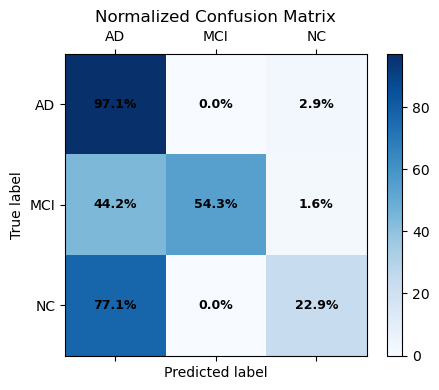

In [31]:
plot_normalized_confusion_matrix_matplotlib(cm_original, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

### Baseline (Random Forest)

In [32]:
# similar to the model defined to fit the original dataset

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_baseline = RandomForestClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

param_grid = {
    "n_estimators": [250],
    "max_depth": [None],
    "class_weight": ["balanced"]
}

rf_selector = GridSearchCV(
    estimator=rf_baseline,
    param_grid=param_grid,
    cv=3,                
    scoring="f1_macro",  
    n_jobs=-1
)

df_base, cm_base, df_base_folds = evaluate_model(
    model_selector=rf_selector,   
    X=X,
    y=y,
    outer_cv=rkf,                 
    model_name="Baseline"
)

print("\n=== Metriche medie (± std, CV) ===")
print(df_base)

print("\n=== Confusion matrix media (CV) ===")
print(cm_base)



=== Metriche medie (± std, CV) ===
                       mean       std     model
accuracy           0.781260  0.021275  Baseline
balanced_accuracy  0.626175  0.040311  Baseline
precision_macro    0.835506  0.031309  Baseline
recall_macro       0.626175  0.040311  Baseline
f1_macro           0.684351  0.040284  Baseline
pr_auc_macro       0.731138  0.045680  Baseline

=== Confusion matrix media (CV) ===
[[157.44   0.     7.36]
 [  9.68  12.56   0.76]
 [ 35.88   0.    21.72]]


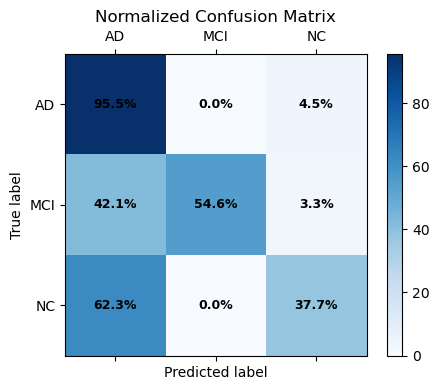

In [33]:
plot_normalized_confusion_matrix_matplotlib(cm_base, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

### Enhanced Random Forest with resampling

A version of the Random Forest addressing class imbalance with random undersampling/oversampling within the training folds.

Since this resampling is applied only to training data within each fold, it does not leak information into test nor validation.

In [34]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# pipeline with both oversampling and undersampling
rf_pipe = Pipeline(steps=[
    ('o', RandomOverSampler(sampling_strategy="auto", random_state=42)),
    ('u', RandomUnderSampler(sampling_strategy="auto", random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [5, 6],
    'clf__min_samples_leaf': [1, 2, 3],
    'clf__max_features': ["sqrt", "log2"]
}

rf_selector = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,        
    n_jobs=-1,
    verbose=2
)

In [35]:
df_adv, cm_adv, df_adv_folds = evaluate_model(
    model_selector=rf_selector,
    X=X,
    y=y,
    outer_cv=rkf,   
    model_name="RF_resampling_tuned"
)

print("\n=== Metriche medie (± std, Nested CV) ===")
print(df_adv)

print("\n=== Confusion matrix media (Nested CV) ===")
print(cm_adv)

params_df = pd.DataFrame(df_adv_folds["best_params"].tolist())
mode_params = params_df.mode().iloc[0].to_dict()

print("\n=== Most frequent parameters ===")
print(mode_params)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each

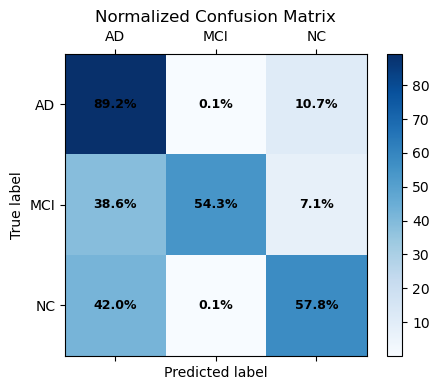

In [36]:
plot_normalized_confusion_matrix_matplotlib(cm_adv, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

### XGBoost with class weighting

Class weighting applied to compensate for imbalanced dataset, by giving higher imporance to underrepresented classes. The model is encouraged to treat all classes more fairly.

In [37]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# computing class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("📊 Class weights:", class_weights)

xgb_pipe = Pipeline(steps=[
    ('clf', XGBClassifier(
        objective="multi:softprob",
        num_class=len(classes),
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    "clf__n_estimators": [125, 150, 175],
    "clf__max_depth": [6, 7],
    "clf__learning_rate": [0.025, 0.050, 0.075],
    "clf__subsample": [0.85, 0.90],
    "clf__colsample_bytree": [0.90, 0.95]
}

xgb_selector = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,        
    n_jobs=-1,
    verbose=2
)

📊 Class weights: {0: 0.4963592233009709, 1: 3.5565217391304347, 2: 1.4201388888888888}


In [38]:
df_xgb, cm_xgb, df_xgb_folds = evaluate_model(
    model_selector=xgb_selector,  
    X=X,
    y=y,
    outer_cv=rkf,                 
    model_name="XGB_weighted",
    class_weights=class_weights   
)

print("\n=== Average metrics (± std, Nested CV) ===")
print(df_xgb)

print("\n=== Average confusion matrix (Nested CV) ===")
print(cm_xgb)

params_df = pd.DataFrame(df_xgb_folds["best_params"].tolist())
mode_params = params_df.mode().iloc[0].to_dict()

print("\n=== Most frequent parameters ===")
print(mode_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 

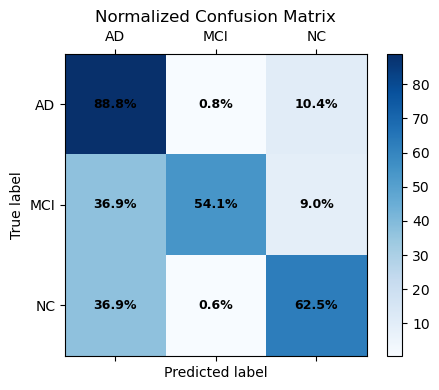

In [39]:
plot_normalized_confusion_matrix_matplotlib(cm_xgb, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

### SVM with RBF kernel with class-weight regularization

Class weighting, also in this case with the goal of reducing the bias towards the majority class without altering the distribution of the original data.

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class_counts_train = y.value_counts().to_dict()
total_train = len(y)
class_weights_train = {cls: total_train/count for cls, count in class_counts_train.items()}
print("📊 Class weights:", class_weights_train)

svm_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid = {
    "clf__C": [75, 100, 125],
    "clf__gamma": [0.0005, 0.001, 0.002, 0.005]
}

svm_selector = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)


📊 Class weights: {0: 1.4890776699029127, 2: 4.260416666666667, 1: 10.669565217391304}


In [41]:
df_svm, cm_svm, df_svm_folds = evaluate_model(
    model_selector=svm_selector,   # inner CV
    X=X,
    y=y,
    outer_cv=rkf,                  # outer CV
    model_name="SVM_RBF_tuned"
)

print("\n=== Average metrics (± std, Nested CV) ===")
print(df_svm)

print("\n=== Average confusion matrix (Nested CV) ===")
print(cm_svm)

params_df = pd.DataFrame(df_svm_folds["best_params"].tolist())
mode_params = params_df.mode().iloc[0].to_dict()

print("\n=== Most frequent parameters ===")
print(mode_params)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each

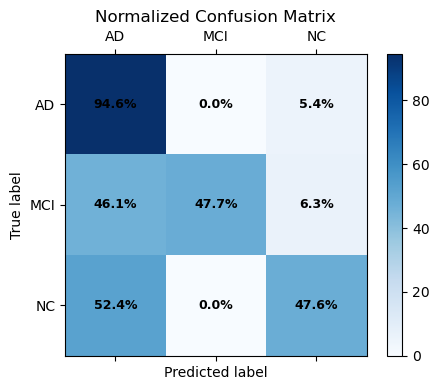

In [42]:
plot_normalized_confusion_matrix_matplotlib(cm_svm, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

### Two-phase strategy (nested CV)

Considered a promising approach because of the hierarchical structure of the prediction problem. 

Instead of directly classifying among all possible classes, the task is split into two sequential step, which allows the model to focus first on a coarser decision and then on a more fine-grained one.

Step 1: XGBoost

In early experiments, XGB appeared to be better able to distinguish positive patient cases from negative ones. For this reason, it was decided to reuse XGB.

In [43]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# =========================
# 1) Step1: binary XGB (AD/MCI vs NC)
# =========================
param_grid_xgb = {
    "n_estimators": [125, 150],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.06, 0.07],
    "subsample": [0.65, 0.70],
    "colsample_bytree": [0.9]
}

rkf_inner_xgb = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
xgb_selector = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring='f1_macro',
    cv=rkf_inner_xgb,
    n_jobs=-1,
    random_state=42,
    verbose=2
)


In early experiments, Random Forest appeared to be more capable of distinguishing between positive patient instances, better identifying the two classes AD and MCI. For this reason, it was decided to reuse Random Forest.

In [44]:
# =========================
# 2) Step2: RF (AD vs MCI)
# =========================
rf_pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_rf = {
    'clf__n_estimators': [300],
    'clf__max_depth': [None, 13, 15],
    'clf__min_samples_split': [3, 4],
    'clf__min_samples_leaf': [1, 2, 3],
    'clf__max_features': ["sqrt", "log2"]
}

rkf_inner_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

rf_selector = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_grid_rf,
    n_iter=20,
    scoring='f1_macro',
    cv=rkf_inner_rf,
    n_jobs=-1,
    random_state=42,
    verbose=2
)


1. the first classifier (XGBoost) predicts whether a sample belongs to one high-level group of classes
2. If the sample falls into the positive subgroup, the second classifier (Random Forest) is applied to determine the final class label.
3. The combination of the two steps yelds the final prediction, leveraging the strenghts of both algorithms in a hierarchical decision process.

In [45]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import pandas as pd

# =========================
# 3) Hierarchical Classifier with Nested CV
# =========================
class HierarchicalClassifierNested(BaseEstimator, ClassifierMixin):
    def __init__(self, model_step1_selector, model_step2_selector):
        self.model_step1_selector = model_step1_selector
        self.model_step2_selector = model_step2_selector
        self.feature_names_in_ = None

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            self.feature_names_in_ = [f"f{i}" for i in range(X.shape[1])]

        # Step1: AD/MCI vs NC
        y_step1 = np.where(y == 2, 0, 1)  # 0=NC, 1=AD/MCI
        self.model_step1_selector.fit(X, y_step1)
        self.model_step1_ = self.model_step1_selector.best_estimator_

        # Step2: AD vs MCI (considering only AD/MCI)
        mask_ad_mci = (y != 2)
        X_step2, y_step2 = X[mask_ad_mci], y[mask_ad_mci]
        self.model_step2_selector.fit(X_step2, y_step2)
        self.model_step2_ = self.model_step2_selector.best_estimator_

        return self

    def predict_proba(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Step1: AD/MCI vs NC
        step1_proba = self.model_step1_.predict_proba(X)
        p_nc = step1_proba[:, 0]
        p_admci = step1_proba[:, 1]

        # Step2: AD vs MCI
        step2_proba = np.zeros((X.shape[0], 2))
        mask_admci = (np.argmax(step1_proba, axis=1) == 1)
        if mask_admci.any():
            X_step2 = X.iloc[mask_admci]
            step2_proba[mask_admci, :] = self.model_step2_.predict_proba(X_step2)

        # Final probabilities
        p_ad = p_admci * step2_proba[:, 0]
        p_mci = p_admci * step2_proba[:, 1]
        final_proba = np.stack([p_ad, p_mci, p_nc], axis=1)
        return final_proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [46]:
# =========================
# 4) Evaluating Nested CV
# =========================
hier_model_nested = HierarchicalClassifierNested(
    model_step1_selector=xgb_selector,
    model_step2_selector=rf_selector
)

df_hier, cm_hier, df_hier_folds = evaluate_model(
    model_selector=hier_model_nested,  
    X=X,
    y=y,
    outer_cv=rkf,
    model_name="Hierarchical_XGB_RF"
)

print("\n=== Average metrics (CV) - Hierarchical_XGB_RF ===")
print(df_hier)

print("\n=== Average confusion matrix (CV) - Hierarchical_XGB_RF ===")
print(cm_hier)

params_step1 = pd.DataFrame(df_hier_folds["best_params_step1"].dropna().tolist())
mode_params_step1 = params_step1.mode().iloc[0].to_dict()

params_step2 = pd.DataFrame(df_hier_folds["best_params_step2"].dropna().tolist())
mode_params_step2 = params_step2.mode().iloc[0].to_dict()

print("\n=== Most frequent parameters (Step1) ===")
print(mode_params_step1)
print("\n=== Most frequent parameters (Step2) ===")
print(mode_params_step2)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 2

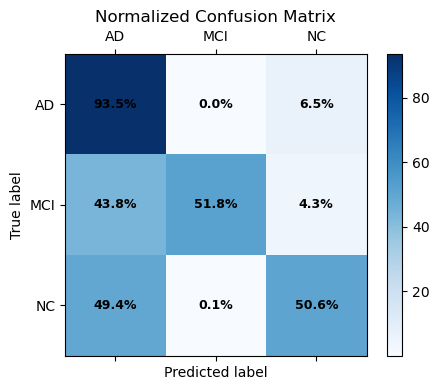

In [47]:
plot_normalized_confusion_matrix_matplotlib(cm_hier, class_labels=["AD", "MCI", "NC"], figsize=(5, 4), percentage=True)

## Evaluation

In [54]:
df_original["model"] = "Original"
df_base["model"] = "Baseline"
df_adv["model"] = "RF_resampling"
df_xgb["model"] = "XGB"
df_svm["model"] = "SVM_RBF_tuned"
df_hier["model"] = "Hierarchical_XGB_RF"

df_results = pd.concat([df_original, df_base, df_adv, df_xgb, df_svm, df_hier], ignore_index=False)

df_results_reset = df_results.reset_index().rename(columns={"index": "metric"})

df_final_table = df_results_reset.pivot(index="model", columns="metric")

df_final_table = df_final_table.sort_index(axis=1, level=1)

print("\n📊 Results: average ± std per model:")
print(df_final_table)



📊 Results: average ± std per model:
                         mean       std              mean               std  \
metric               accuracy  accuracy balanced_accuracy balanced_accuracy   
model                                                                         
Baseline             0.781260  0.021275          0.626175          0.040311   
Hierarchical_XGB_RF  0.795274  0.022449          0.653007          0.042133   
Original             0.756479  0.018152          0.580757          0.038690   
RF_resampling        0.785661  0.022127          0.671038          0.043318   
SVM_RBF_tuned        0.791519  0.017128          0.632813          0.038600   
XGB                  0.793977  0.021101          0.684790          0.038237   

                         mean       std         mean          std  \
metric               f1_macro  f1_macro pr_auc_macro pr_auc_macro   
model                                                               
Baseline             0.684351  0.040284     

### Comparison between models

For the statistical comparison between models, we have chosen:

- Balanced Accuracy - accounts for class imbalance by averaging recall across classes, preventing dominant classes from biasing the overall score

- F1-macro - computer the F1 score per class and averages them, ensuring all classes are equally weighted in performance evaluation

- PR-AUC macro - evaluates precision-recall trade offs per class, which is particularli informative when positive classes are underrepresented.

### Comparison between baselines

Comparison between results obtained from the unreduced and reduced version of the dataset over the baseline.

It is important to ensure that the reduction in the dataset has been decisive in improving performance.

We applied independent t-test because we can consider the models to be trained on different datasets.

In [49]:
from scipy.stats import ttest_ind

# Chosen metrics to compare
metrics = ["balanced_accuracy", "f1_macro", "pr_auc_macro"]

print("=== Independent t-tests: Baseline PCA vs Baseline Original ===")

for metric in metrics:
    print(f"\n--- Metric: {metric} ---")
    
    pca_vals = df_base_folds[metric].values
    original_vals = df_original_folds[metric].values

    t_stat, p_val = ttest_ind(pca_vals, original_vals, equal_var=False)
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.8f}")


=== Independent t-tests: Baseline PCA vs Baseline Original ===

--- Metric: balanced_accuracy ---
t-statistic = 4.064, p-value = 0.00017809

--- Metric: f1_macro ---
t-statistic = 4.888, p-value = 0.00001181

--- Metric: pr_auc_macro ---
t-statistic = 2.380, p-value = 0.02133439


Paired t-test + Wilcoxon signed rank because all models were evaluated on the same cross-validation folds, meaning that each fold provides a paired observation for every model.

- paired t-test applied on nested k-fold cross validation results may underestimate variability due to the dependency between training and validation splits.

- Wilcoxon signed-rank test is a non parametric-test, not assuming normality of differences, providing a robust confirmation of the paired t-test results, increasing confidence in the statistical significance of observed performance gaps between models.

In [50]:
from scipy.stats import ttest_rel, wilcoxon

# Same metrics as before
metrics = ["balanced_accuracy", "f1_macro", "pr_auc_macro"]

# Dictionary of dataframes for each model
folds_dict = {
    "Baseline": df_base_folds,
    "RF_resampling": df_adv_folds,
    "SVM_RBF": df_svm_folds,
    "XGB_weighted": df_xgb_folds,
    "Hierarchical": df_hier_folds
}

print("=== Paired t-tests and Wilcoxon signed-rank test with Baseline ===")

for metric in metrics:
    print(f"\n--- Metric: {metric} ---")
    
    base_vals = folds_dict["Baseline"][metric].values

    # Comparing baseline with each other model
    for model_name in ["RF_resampling", "SVM_RBF", "XGB_weighted", "Hierarchical"]:
        comp_vals = folds_dict[model_name][metric].values

        # Paired t-test
        t_stat, p_val_t = ttest_rel(base_vals, comp_vals)

        # Wilcoxon signed-rank test
        try:
            w_stat, p_val_w = wilcoxon(base_vals, comp_vals)
        except ValueError:
            # Se tutte le differenze sono nulle, Wilcoxon solleva errore
            w_stat, p_val_w = (0, 1.0)

        print(f"Baseline vs {model_name}:")
        print(f"   t-test:     t={t_stat:.3f}, p={p_val_t:.8f}")
        print(f"   Wilcoxon:   W={w_stat:.3f}, p={p_val_w:.8f}")

    # Example comparison between two top candidates (XGB vs Hierarchical)
    hier_vals = folds_dict["Hierarchical"][metric].values
    xgb_vals = folds_dict["XGB_weighted"][metric].values
    t_stat, p_val_t = ttest_rel(hier_vals, xgb_vals)
    try:
        w_stat, p_val_w = wilcoxon(hier_vals, xgb_vals)
    except ValueError:
        w_stat, p_val_w = (0, 1.0)

    print(f"Hierarchical vs XGB_weighted:")
    print(f"   t-test:     t={t_stat:.3f}, p={p_val_t:.8f}")
    print(f"   Wilcoxon:   W={w_stat:.3f}, p={p_val_w:.8f}")


=== Paired t-tests and Wilcoxon signed-rank test with Baseline ===

--- Metric: balanced_accuracy ---
Baseline vs RF_resampling:
   t-test:     t=-10.789, p=0.00000000
   Wilcoxon:   W=0.000, p=0.00000006
Baseline vs SVM_RBF:
   t-test:     t=-1.301, p=0.20569853
   Wilcoxon:   W=113.000, p=0.19081426
Baseline vs XGB_weighted:
   t-test:     t=-14.677, p=0.00000000
   Wilcoxon:   W=0.000, p=0.00000006
Baseline vs Hierarchical:
   t-test:     t=-5.710, p=0.00000698
   Wilcoxon:   W=19.000, p=0.00001830
Hierarchical vs XGB_weighted:
   t-test:     t=-8.351, p=0.00000001
   Wilcoxon:   W=0.000, p=0.00000006

--- Metric: f1_macro ---
Baseline vs RF_resampling:
   t-test:     t=-7.803, p=0.00000005
   Wilcoxon:   W=7.000, p=0.00000113
Baseline vs SVM_RBF:
   t-test:     t=-1.313, p=0.20152901
   Wilcoxon:   W=112.000, p=0.18172985
Baseline vs XGB_weighted:
   t-test:     t=-8.514, p=0.00000001
   Wilcoxon:   W=6.000, p=0.00000083
Baseline vs Hierarchical:
   t-test:     t=-5.516, p=0.000011

### Graphical visualizaiton of results

c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


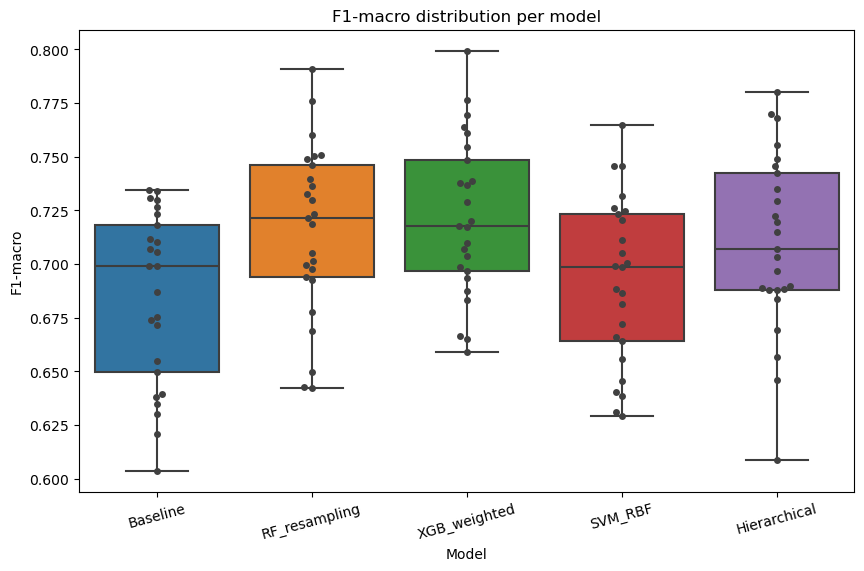

c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


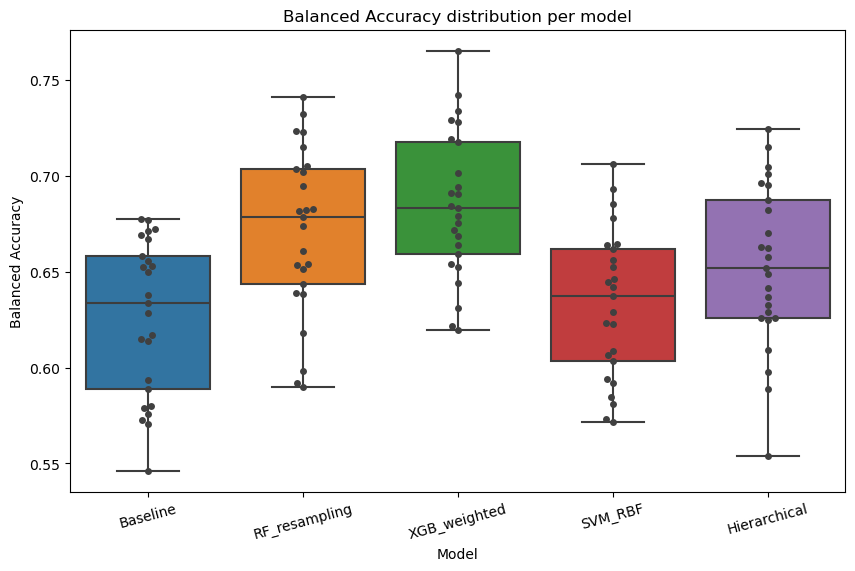

c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\e1204\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


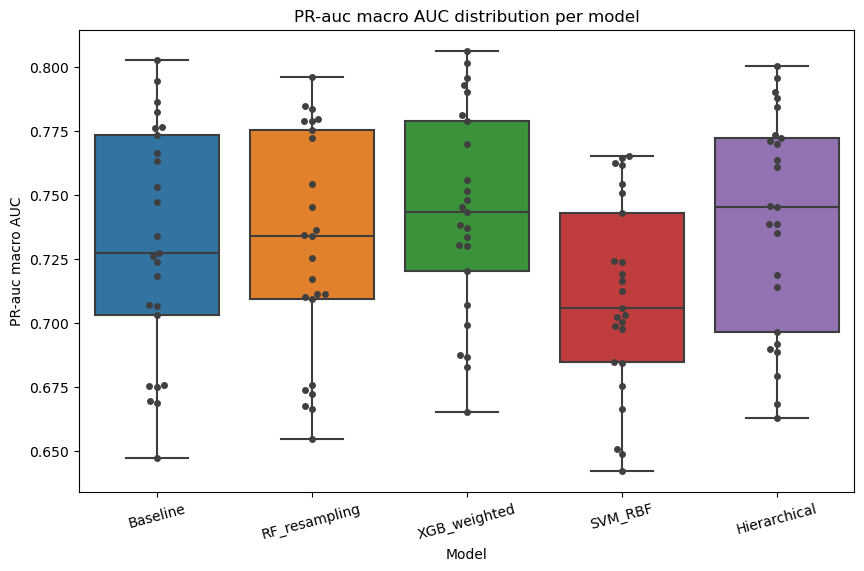

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_base_folds['model'] = 'Baseline'
df_adv_folds['model'] = 'RF_resampling'
df_xgb_folds['model'] = 'XGB_weighted'
df_svm_folds['model'] = 'SVM_RBF' 
df_hier_folds['model'] = 'Hierarchical'

df_all_folds = pd.concat([df_base_folds, df_adv_folds, df_xgb_folds, df_svm_folds, df_hier_folds], ignore_index=True)

# --- Boxplot for F1-macro ---
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="f1_macro", data=df_all_folds)
sns.swarmplot(x="model", y="f1_macro", data=df_all_folds, color=".25")
plt.title("F1-macro distribution per model")
plt.ylabel("F1-macro")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()

# --- Boxplot for Balanced Accuracy ---
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="balanced_accuracy", data=df_all_folds)
sns.swarmplot(x="model", y="balanced_accuracy", data=df_all_folds, color=".25")
plt.title("Balanced Accuracy distribution per model")
plt.ylabel("Balanced Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()

# --- Boxplot for PR-auc macro AUC ---
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="pr_auc_macro", data=df_all_folds)
sns.swarmplot(x="model", y="pr_auc_macro", data=df_all_folds, color=".25")
plt.title("PR-auc macro AUC distribution per model")
plt.ylabel("PR-auc macro AUC")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()
